# Classificação de imagens usando VGG16

Utilizada a base de dados HAR encontrada no kaggle - https://www.kaggle.com/datasets/meetnagadia/human-action-recognition-har-dataset

Usado o modelo pré-treinado VGG16 do keras

Resultados com imagens 60x60, tamanho do batch igual a 20 e 100 épocas:



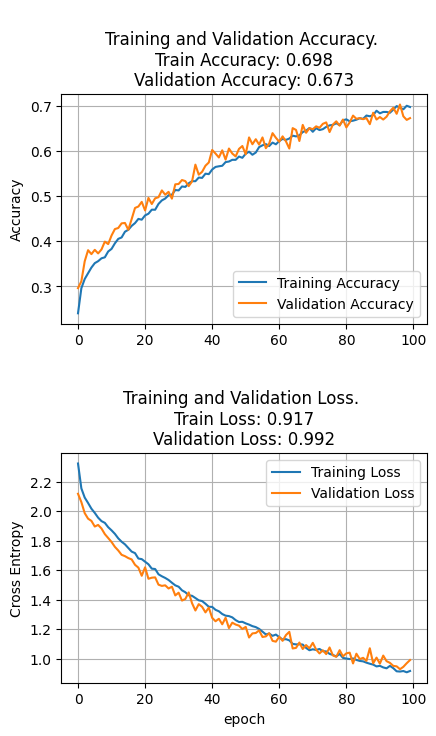

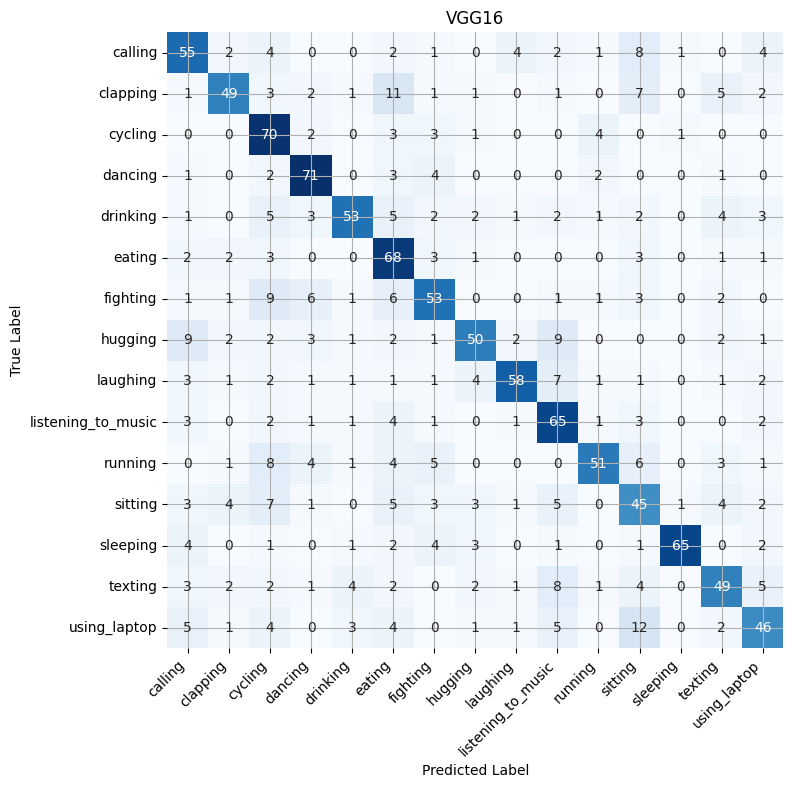



-----


#Conectando ao Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/Human Action Recognition

!ls

/content/gdrive/.shortcut-targets-by-id/1-v99lsXTOXIVTZaihTcMBvhkqKIglc46/Human Action Recognition
'Cópia de Completo - VGG16 Human Actions Recognition.ipynb'
'Inception Human Actions Recognition.ipynb'
 test
 Testing_set.csv
 train
 Training_set.csv
'VGG16 Human Actions Recognition.ipynb'


#Importando bibliotecas

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import glob
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import (Conv2D, Dropout, MaxPool2D, Flatten, Dense, BatchNormalization,)
import seaborn as sns
from sklearn.metrics import confusion_matrix

#Importando o dataset

In [28]:
# dataframe
train_df = pd.read_csv(r"/content/gdrive/MyDrive/Human Action Recognition/Training_set.csv")
test_df = pd.read_csv(r"/content/gdrive/MyDrive/Human Action Recognition/Testing_set.csv")

path = "/content/gdrive/MyDrive/Human Action Recognition"

In [ ]:
img_height = 60
img_width = 60
num_classes = 15
batch = 20

In [29]:
valid_df = train_df.groupby('label').apply(lambda x: x.sample(frac=0.10))
valid_df = valid_df.droplevel(0)
training_df = train_df.drop(valid_df.index)

In [30]:
train_df.head()

,filename,label
0,Image_1.jpg,sitting
1,Image_2.jpg,using_laptop
2,Image_3.jpg,hugging
3,Image_4.jpg,sleeping
4,Image_5.jpg,using_laptop


In [31]:
freq = train_df['label'].value_counts()
train_freq = training_df['label'].value_counts()
valid_freq = valid_df['label'].value_counts()

print(freq,"\n\n", train_freq,"\n\n",valid_freq)
print()



sitting               840
using_laptop          840
hugging               840
sleeping              840
drinking              840
clapping              840
dancing               840
cycling               840
calling               840
laughing              840
eating                840
fighting              840
listening_to_music    840
running               840
texting               840
Name: label, dtype: int64 

 sitting               756
using_laptop          756
hugging               756
sleeping              756
drinking              756
clapping              756
dancing               756
cycling               756
calling               756
laughing              756
eating                756
fighting              756
listening_to_music    756
running               756
texting               756
Name: label, dtype: int64 

 calling               84
clapping              84
cycling               84
dancing               84
drinking              84
eating                84
fighting    

#Organizando os dados

In [32]:
gen = ImageDataGenerator(rescale         = 1./255.,
                         horizontal_flip = True,
                         vertical_flip   = False,
                         zoom_range      = 0.05,
                         rotation_range  = 25)

train_generator = gen.flow_from_dataframe(
    train_df, # dataframe
    directory = path + "/train", # images data path / folder in which images are there
    x_col = 'filename',
    y_col = 'label',
    color_mode = "rgb",
    target_size = (img_height, img_width), # image height , image width
    class_mode = "categorical",
    batch_size = batch,
    shuffle = True,
    seed = 42)

Found 12600 validated image filenames belonging to 15 classes.


In [33]:
test_gen = ImageDataGenerator(rescale = 1./255.)

validation_generator = test_gen.flow_from_dataframe(
    valid_df,
    directory   = path + "/train",
    x_col       = 'filename',
    y_col       = 'label',
    color_mode  ="rgb",
    target_size = (img_height, img_width), # image height , image width
    class_mode  = "categorical",
    batch_size  = batch,
    shuffle     = False,
    seed        = 42)

Found 1260 validated image filenames belonging to 15 classes.


In [34]:
a = train_generator.class_indices
class_names = list(a.keys())
class_names

['calling',
 'clapping',
 'cycling',
 'dancing',
 'drinking',
 'eating',
 'fighting',
 'hugging',
 'laughing',
 'listening_to_music',
 'running',
 'sitting',
 'sleeping',
 'texting',
 'using_laptop']

#Criando o modelo

In [35]:
# usando modelo pre treinado do keras
vgg_model = Sequential()

pretrained_model= tf.keras.applications.VGG16(include_top=False,
                   input_shape=(img_height,img_width,3),
                   pooling='avg',classes=num_classes,
                   weights='imagenet')

# mudar os pesos das camadas para 0
for layer in pretrained_model.layers:
        layer.trainable=False

# criar o modelo final
vgg_model.add(pretrained_model) #modelo vgg é uma camada do nosso modelo
vgg_model.add(Flatten())
vgg_model.add(Dense(512, activation='relu'))
vgg_model.add(Dense(num_classes, activation='softmax'))

#Treinando o modelo

In [36]:
# compilar o modelo
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
vgg_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dense_5 (Dense)             (None, 15)                7695      
                                                                 
Total params: 14985039 (57.16 MB)
Trainable params: 270351 (1.03 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [37]:
epochs = 100
history = vgg_model.fit(train_generator, epochs=epochs, verbose=1, validation_data=validation_generator, batch_size=batch)
#(x=train_gen,  epochs=10, verbose=1, callbacks=callbacks,  validation_data=valid_gen, validation_steps=None,  shuffle=False,  initial_epoch=0)

Epoch 1/100
630/630 [==============================] - 59s 91ms/step - loss: 2.3231 - accuracy: 0.2402 - val_loss: 2.1180 - val_accuracy: 0.2960
Epoch 2/100
630/630 [==============================] - 56s 89ms/step - loss: 2.1544 - accuracy: 0.2959 - val_loss: 2.0616 - val_accuracy: 0.3111
Epoch 3/100
630/630 [==============================] - 56s 90ms/step - loss: 2.0921 - accuracy: 0.3163 - val_loss: 1.9866 - val_accuracy: 0.3556
Epoch 4/100
630/630 [==============================] - 60s 95ms/step - loss: 2.0556 - accuracy: 0.3290 - val_loss: 1.9493 - val_accuracy: 0.3802
Epoch 5/100
630/630 [==============================] - 55s 87ms/step - loss: 2.0168 - accuracy: 0.3417 - val_loss: 1.9341 - val_accuracy: 0.3714
Epoch 6/100
630/630 [==============================] - 55s 87ms/step - loss: 1.9883 - accuracy: 0.3514 - val_loss: 1.8960 - val_accuracy: 0.3810
Epoch 7/100
630/630 [==============================] - 54s 86ms/step - loss: 1.9561 - accuracy: 0.3558 - val_loss: 1.9068 - val_ac

In [38]:
vgg_model.save_weights("/content/gdrive/MyDrive/Human Action Recognition/Pesos Modelo")

#Gráficos do modelo

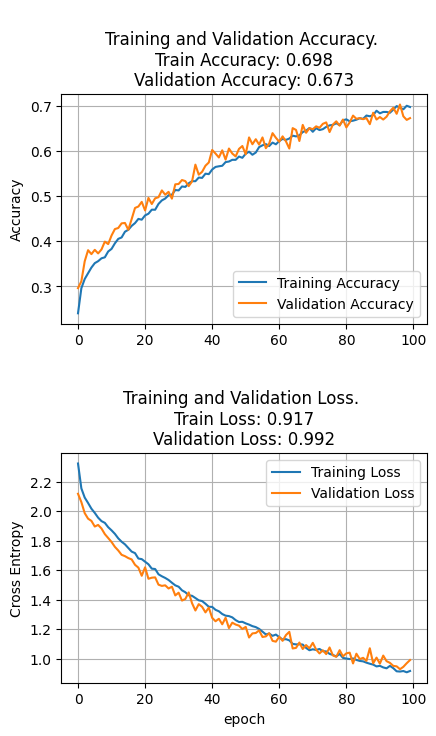

In [39]:
# acurácia
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# plot results
# accuracy
plt.figure(figsize=(5, 8))
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['font.size'] = 10
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'\nTraining and Validation Accuracy. \nTrain Accuracy: {str(round(acc[-1],3))}\nValidation Accuracy: {str(round(val_acc[-1],3))}')

# loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(round(loss[-1],3))}\nValidation Loss: {str(round(val_loss[-1],3))}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

63/63 [==============================] - 5s 80ms/step


'fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)\nfig.tight_layout()\nfig.subplots_adjust(top=1.25)\nplt.show()'

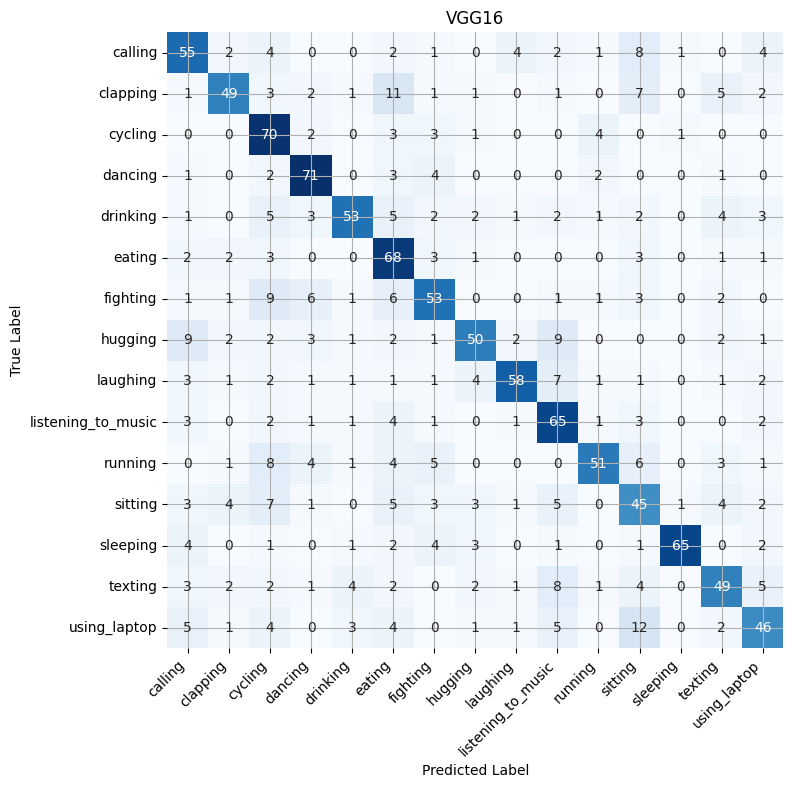

In [43]:
def plot_heatmap(y_true, y_pred, class_names, ax, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm,
        annot=True,
        square=True,
        xticklabels=class_names,
        yticklabels=class_names,
        fmt='d',
        cmap=plt.cm.Blues,
        cbar=False,
        ax=ax)
    ax.set_title(title, fontsize = 12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = "right")
    ax.set_ylabel('True Label', fontsize= 10)
    ax.set_xlabel('Predicted Label', fontsize = 10)

validation_generator.reset()

fig, (ax1) = plt.subplots(1, 1, figsize=(15, 8))

vgg16_val_preds = vgg_model.predict(validation_generator)
vgg16_val_pred_classes = np.argmax(vgg16_val_preds, axis=1)

plt.title("Confusion Matrix")

true_classes = validation_generator.classes

plot_heatmap(true_classes, vgg16_val_pred_classes, class_names, ax1, title = "VGG16")

"""fig.suptitle("Confusion Matrix Model Comparison", fontsize = 15)
fig.tight_layout()
fig.subplots_adjust(top=1.25)
plt.show()"""

In [41]:
vgg_model.metrics_names

['loss', 'accuracy']